<h4>Tranfer Learning</h4>

<p> Zie <a href="https://www.tensorflow.org/tutorials/images/transfer_learning">LINK</a> voor transfer learning op Tensorflow.

In [1]:
# load Tensorboard
%load_ext tensorboard

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
import datetime

2022-11-16 13:54:42.580915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
time_save = now.strftime("%Hh%M")
dt_save = now.strftime("%d%m%Y")
# print("ddmmyyyy =", dt_save)
# print("HMS =", time_save)

# folder path to save model 
sp_model = r'saved_models/tl_mobileNetV2_2/model/'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
# print('File count:', sc_model)

<h4>Warning blokker</h4>
<p>De lagen in een model geven een warning. De code hieronder blokced het tonen hiervan.</p>    
    

In [4]:
tf.get_logger().setLevel('ERROR')

In [5]:
# load dataset 

test_data_dir = '../data/Test'
train_data_dir = '../data/Train'


data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)
edgeFiles = list()
testFiles = list()

for filename in os.listdir(train_data_dir):
    imgAppleDirectory = os.path.join(train_data_dir, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)
    
for filename in os.listdir(test_data_dir):
    imgAppleTestDirectory = os.path.join(test_data_dir, filename)
    testFiles.append(imgAppleTestDirectory) 
    # print(testFiles)

In [6]:
batch_size = 16
img_size= (224, 224)

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


2022-11-16 13:54:49.106303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [9]:
# Test set 

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


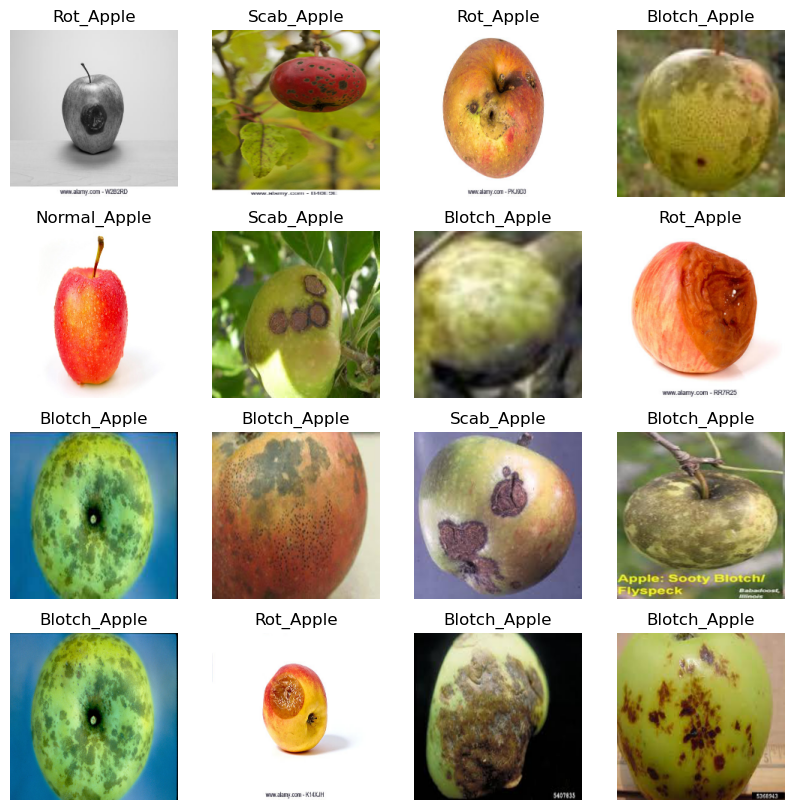

In [10]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# confic dataset for performence 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
# add augmentation
img_height = 224
img_width = 224

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(45.5),
  layers.RandomZoom(0.6),  
])

In [13]:
# augmentation toegevoegen
image, label = next(iter(train_ds))
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

<h4>Base Mobel</h4>
<p>Hier wordt het voorgetrainde model ingeladen</p>

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [15]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch =  next(iter(train_ds))
feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [17]:
#Freeze the convolutional base
base_model.trainable = False

<h4>Classification head</h4>

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [19]:
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [20]:
#base model architecture
# base_model.summary()

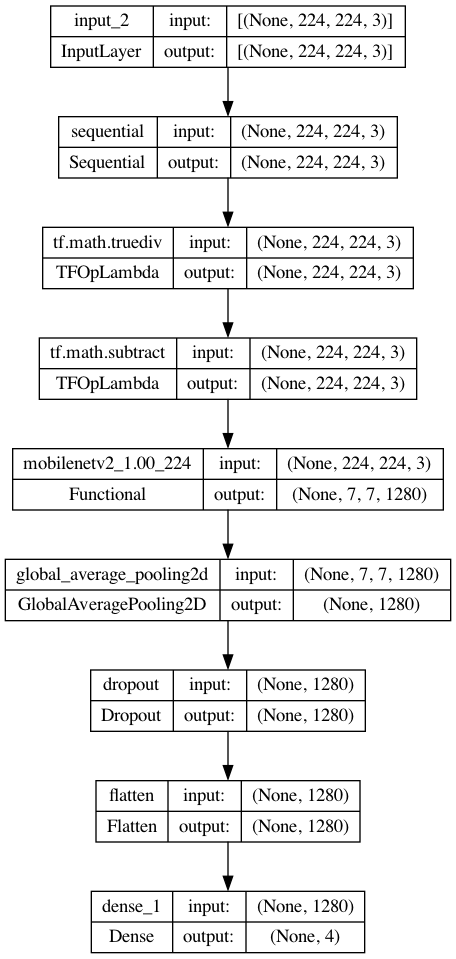

In [21]:
num_classes = 4
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
outputs = prediction_layer(x)
preds=Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs=preds)
keras.utils.plot_model(model, show_shapes=True)

In [22]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_2
1 sequential
2 tf.math.truediv
3 tf.math.subtract
4 mobilenetv2_1.00_224
5 global_average_pooling2d
6 dropout
7 flatten
8 dense_1


<h4>Model</h4>

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [25]:
len(model.trainable_variables)

2

<h4>Model Training</h4>

In [26]:
initial_epochs = 25
loss0, accuracy0 = model.evaluate(val_ds)

5/5 [==============================] - 3s 283ms/step - loss: 1.7465 - accuracy: 0.2500


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.75
initial accuracy: 0.25


In [28]:
# add Tensorboard
log_dir = "logs/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 1/25
 4/20 [=====>........................] - ETA: 6s - loss: 1.8574 - accuracy: 0.2031

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('saved_models/tl_mobileNetV2_2/plt_val_acc/tl_freese_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


<h4>UN-FREESE</h4>

In [ ]:
base_model.trainable = True

In [ ]:
print("Aantal layers in het basis model: ", len(base_model.layers))

In [ ]:
fine_tune_at = 100

# Freeze alle layers voor 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

<h4>Het model terug samenstellen</h4>

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

<h4>Voortzetting Model training, na de Un-Freese</h4>

In [ ]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0,5.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
plt.savefig('saved_models/tl_mobileNetV2_2/plt_val_acc/tl_UNfreese_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()

In [ ]:
model.save('saved_models/tl_mobileNetV2/model/tl_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.h5')

<h4>Confusion Matrix</h4>

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch', 'Normal', 'Rot', 'Scab'])

cm_display.plot()
plt.savefig('saved_models/tl_mobileNetV2_2/plt_matrix/tl_matrix_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


###### <h4>Evaluatie en voorspelling</h4>

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# run Tensorbord
%tensorboard --logdir logs/